<a href="https://colab.research.google.com/github/rabiaabass/CV_HTML/blob/master/05_Derin_%C3%96%C4%9Frenme_Optimizasyon_Al%C4%B1%C5%9Ft%C4%B1rmalar%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kapsamlı Optimizasyon Alıştırmaları

## Derin Öğrenmeye Derinlemesine Bakış

---

### 🎯 Bu Notebook'un Amacı

Bu notebook, önceki çalışmalarda öğrendiğimiz gradyan inişi, hiperparametre ayarı ve öğrenme oranı stratejileri gibi konuları birleştirerek bilginizi pekiştirmek ve derinleştirmek için tasarlanmıştır. Her bir alıştırma, sizi gerçek dünya derin öğrenme problemlerinde karşılaşacağınız zorluklara hazırlayacak pratik bir senaryo sunar.

**Bu alıştırmalarla şunları öğreneceksiniz:**

1.  **Momentumun Gücü:** Standart gradyan inişini, dar vadilerde daha hızlı ilerlemesini sağlayan momentum ile nasıl geliştireceğimizi.
2.  **Öğrenme Oranı Zamanlayıcısı:** Popüler bir öğrenme oranı stratejisi olan "Basamaklı Azalma"yı (Step Decay) nasıl kodlayacağımızı.
3.  **Erken Durdurma Mantığı:** Aşırı öğrenmeyi (overfitting) önleyen en önemli tekniklerden biri olan "Erken Durdurma" (Early Stopping) algoritmasını nasıl simüle edeceğimizi.
4.  **Modern Optimize Ediciler:** Günümüzün standardı olan Adam optimize edicisinin basitleştirilmiş bir versiyonunu sıfırdan nasıl yazacağımızı.
5.  **Sistematik Arama:** En iyi hiperparametreleri bulmak için temel bir "Izgara Taraması" (Grid Search) nasıl yapacağımızı.

In [1]:
# Gerekli kütüphanelerin yüklenmesi
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Callable, Tuple

# Grafiklerin stil ayarları
sns.set_theme(style="whitegrid")
print(f"PyTorch versiyonu: {torch.__version__}")

PyTorch versiyonu: 2.8.0+cu126


## Hazırlık: Test Fonksiyonları ve Yardımcı Araçlar

Alıştırmalarda kullanacağımız test fonksiyonlarını ve görselleştirme araçlarını burada tanımlayalım.

In [2]:
# --- Test Fonksiyonları (Vektörize Edilmiş) ---

def himmelblau(xy: torch.Tensor) -> torch.Tensor:
    """Çoklu minimuma sahip Himmelblau test fonksiyonu. Hem tekil hem de toplu girdilerle çalışır."""
    if xy.dim() == 1:
        xy = xy.unsqueeze(0) # Tekil girdiyi toplu formata çevir

    x, y = xy[:, 0], xy[:, 1]
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def rosenbrock(xy: torch.Tensor) -> torch.Tensor:
    """Dar ve kavisli bir vadiye sahip Rosenbrock fonksiyonu. Hem tekil hem de toplu girdilerle çalışır."""
    if xy.dim() == 1:
        xy = xy.unsqueeze(0)

    x, y = xy[:, 0], xy[:, 1]
    return (1 - x)**2 + 100 * (y - x**2)**2

# --- Görselleştirme Yardımcı Fonksiyonu ---

def plot_paths(
    paths: Dict[str, np.ndarray],
    func: Callable[[torch.Tensor], torch.Tensor],
    title: str,
    x_range: Tuple[float, float] = (-5, 5),
    y_range: Tuple[float, float] = (-5, 5)
) -> None:
    """Farklı optimizasyon yollarını bir kontur grafiği üzerinde çizer."""
    x_vals = np.linspace(x_range[0], x_range[1], 200)
    y_vals = np.linspace(y_range[0], y_range[1], 200)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Izgaradaki her nokta için fonksiyon değerini hesapla
    grid_points = np.stack([X.ravel(), Y.ravel()]).T
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)
    Z = func(grid_tensor).detach().numpy().reshape(X.shape)

    plt.figure(figsize=(12, 10))
    # Logaritmik ölçekleme ve seviye sayısı ayarı
    levels = np.logspace(np.log10(Z[Z>0].min()+1e-6), np.log10(Z.max()), 35)
    plt.contourf(X, Y, Z, levels=levels, cmap='viridis', norm='log')
    plt.colorbar(label='f(x, y) Değeri (Log Skalası)')

    for name, path in paths.items():
        plt.plot(path[:, 0], path[:, 1], '-o', markersize=3, label=name)

    # Minimum noktaları işaretleme (isteğe bağlı, fonksiyonlara göre değişir)
    if func.__name__ == 'himmelblau':
       minima = np.array([[3.0, 2.0], [-2.805118, 3.131312], [-3.779310, -3.283186], [3.584428, -1.848126]])
       plt.plot(minima[:, 0], minima[:, 1], 'r*', markersize=15, label='Minimumlar')
    elif func.__name__ == 'rosenbrock':
       minimum = np.array([[1.0, 1.0]])
       plt.plot(minimum[:, 0], minimum[:, 1], 'r*', markersize=15, label='Minimum')

    plt.title(title, fontsize=16)
    plt.xlabel('x Ekseni')
    plt.ylabel('y Ekseni')
    plt.legend()
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.show()

---
## Alıştırma 1: Momentumun Gücü

**Amaç:** Standart gradyan inişini, momentum ekleyerek geliştirmek.

**Teori:** Momentum, optimizasyon adımlarına bir tür "ivme" katar. Önceki adımların yönünü de hesaba katarak, dar vadilerde daha hızlı ilerlemeyi ve sığ yerel minimumlardan kaçmayı sağlar.
- **Güncelleme Kuralı:**
  - $v_t = \beta v_{t-1} + \alpha \nabla f(x_{t-1})$
  - $x_t = x_{t-1} - v_t$
  (Burada $v$ hız, $\beta$ momentum katsayısı, $\alpha$ öğrenme oranıdır.)

**Göreviniz:** Aşağıdaki `gradient_descent_with_momentum` fonksiyonunu, yukarıdaki güncelleme kuralını uygulayacak şekilde tamamlayın. Ardından, standart gradyan inişi ile momentumlu versiyonu, zorlu **Rosenbrock** fonksiyonu üzerinde karşılaştırın.

Son nokta (GD):       [0.6541273  0.42621106]
Son nokta (Momentum): [0.99992096 0.99984145]


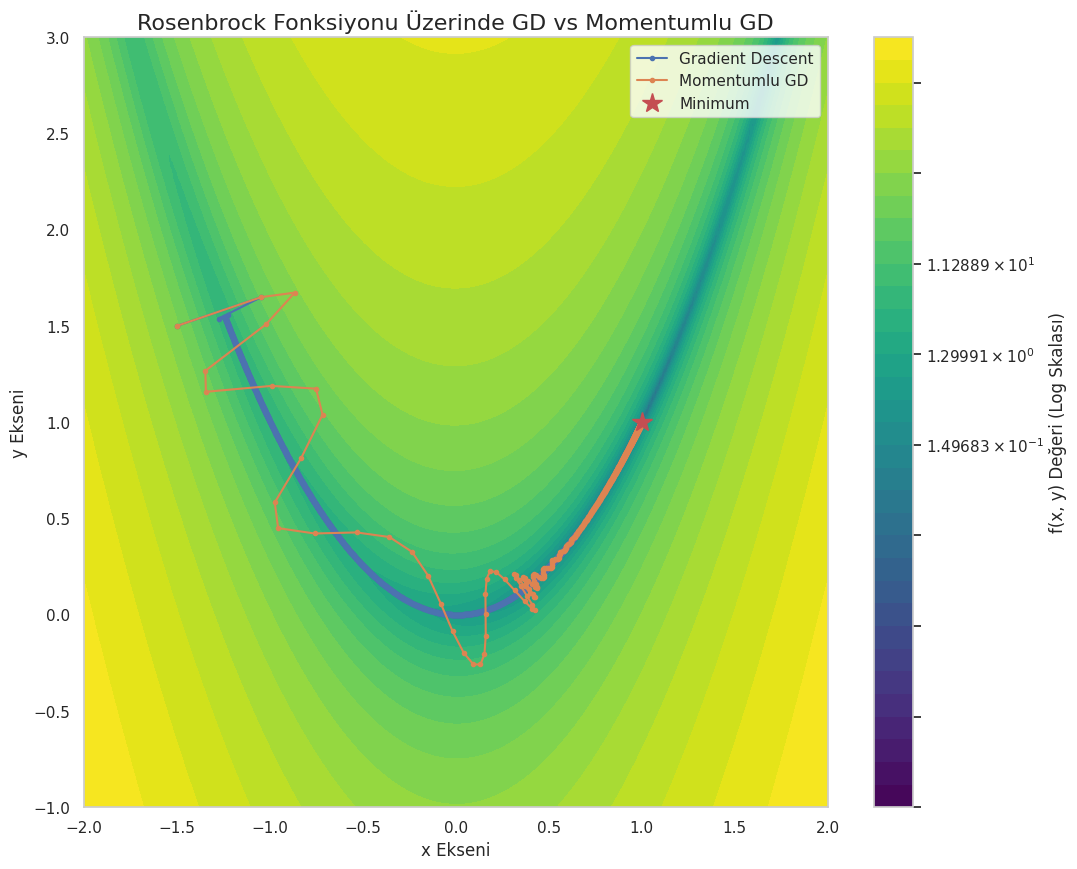

In [6]:
# def gradient_descent_with_momentum(
#     start_xy: List[float],
#     func: Callable[[torch.Tensor], torch.Tensor],
#     lr: float,
#     iters: int,
#     beta: float = 0.9
# ) -> np.ndarray:

#     xy = torch.tensor(start_xy, dtype=torch.float32, requires_grad=True)
#     history: List[List[float]] = []
#     # Hız (velocity) tensörünü sıfır olarak başlatın
#     velocity = torch.zeros_like(xy)

#     for _ in range(iters):
#         history.append(xy.detach().clone().tolist())
#         loss = func(xy)
#         loss.backward()

#         grad = xy.grad
#         if grad is not None:
#             with torch.no_grad():
#                 # --- KODUNUZU BURAYA YAZIN ---
#                 # 1. Hız (velocity) tensörünü güncelleyin.
#                 # İpucu: v_t = beta * v_{t-1} + lr * grad


#                 # 2. Parametre (xy) tensörünü yeni hız ile güncelleyin.
#                 # İpucu: xy = xy - velocity

#                 # --- KODUNUZ BİTTİ ---

#             # Gradyanları sıfırlama (bir sonraki iterasyon için önemli)
#             if xy.grad is not None:
#                  xy.grad.zero_()

#     return np.array(history)
def gradient_descent(
    start_xy: List[float],
    func: Callable[[torch.Tensor], torch.Tensor],
    lr: float,
    iters: int
) -> np.ndarray:

    xy = torch.tensor(start_xy, dtype=torch.float32, requires_grad=True)
    history: List[List[float]] = []

    for _ in range(iters):
        history.append(xy.detach().clone().tolist())

        loss = func(xy).sum()   # vektörize fonksiyon için güvenli
        loss.backward()

        with torch.no_grad():
            xy -= lr * xy.grad

        xy.grad.zero_()

    return np.array(history)
def gradient_descent_with_momentum(
    start_xy: List[float],
    func: Callable[[torch.Tensor], torch.Tensor],
    lr: float,
    iters: int,
    beta: float = 0.9
) -> np.ndarray:

    xy = torch.tensor(start_xy, dtype=torch.float32, requires_grad=True)
    history: List[List[float]] = []
    velocity = torch.zeros_like(xy)  # v_0 = 0

    for _ in range(iters):
        history.append(xy.detach().clone().tolist())

        loss = func(xy).sum()  # (N,) gelse bile skalarlaştır
        loss.backward()

        grad = xy.grad
        if grad is not None:
            with torch.no_grad():
                # v_t = beta * v_{t-1} + lr * grad
                velocity = beta * velocity + lr * grad
                # x_t = x_{t-1} - v_t
                xy -= velocity

            xy.grad.zero_()

    return np.array(history)

# --- Rosenbrock Üzerinde Karşılaştırma ---

start = [-1.5, 1.5]
iters = 2000
lr = 0.001

path_gd = gradient_descent(start, rosenbrock, lr=lr, iters=iters)
path_mom = gradient_descent_with_momentum(start, rosenbrock, lr=lr, iters=iters, beta=0.9)

print("Son nokta (GD):      ", path_gd[-1])
print("Son nokta (Momentum):", path_mom[-1])

paths = {
    "Gradient Descent": path_gd,
    "Momentumlu GD": path_mom
}

plot_paths(paths, rosenbrock, title="Rosenbrock Fonksiyonu Üzerinde GD vs Momentumlu GD",
           x_range=(-2, 2), y_range=(-1, 3))

### Alıştırma 1: Çalıştırma ve Karşılaştırma

Aşağıdaki kod bloğu, yazdığınız `gradient_descent_with_momentum` fonksiyonunu ve standart gradyan inişini (hazır verilmiştir) **Rosenbrock** fonksiyonu üzerinde çalıştıracak ve sonuçları görselleştirecektir. Herhangi bir değişiklik yapmanıza gerek yoktur, sadece çalıştırıp momentumun etkisini gözlemleyin.

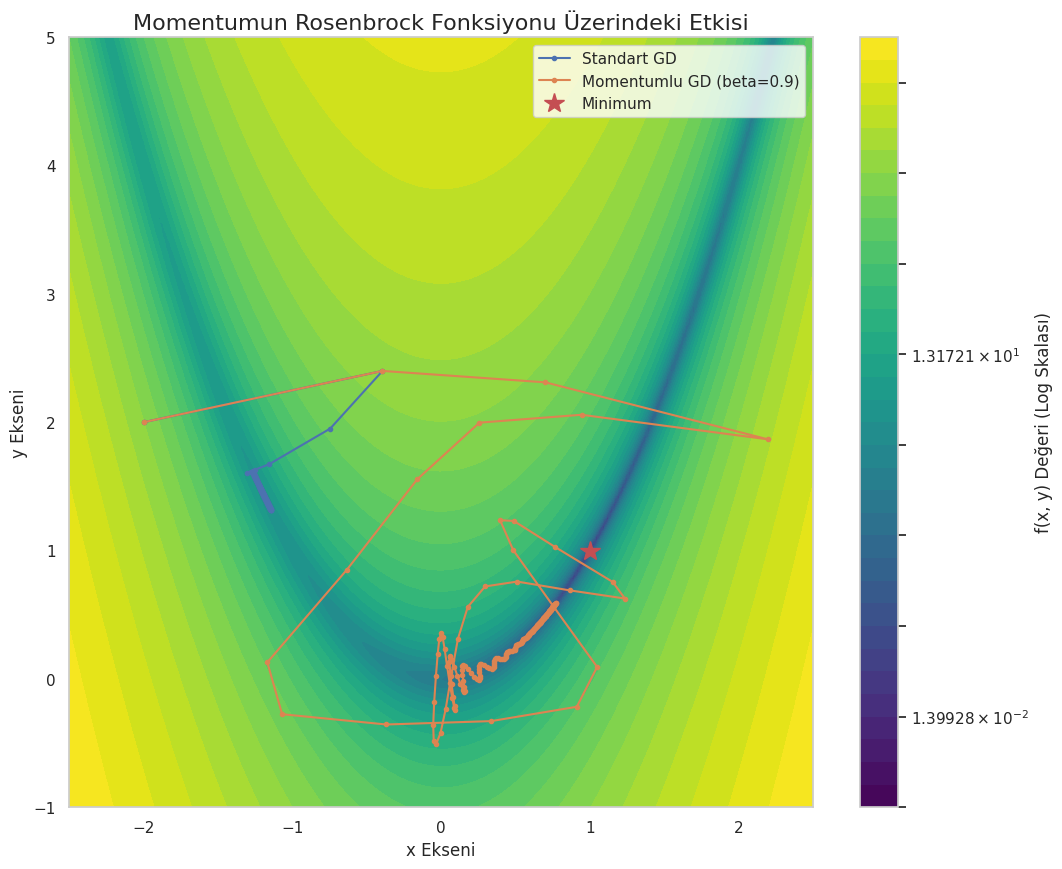

Görselleştirme başarılı! Momentumlu versiyonun dar vadide nasıl ilerlediğini gözlemleyin.


In [5]:
# Standart GD için Pylance uyumlu bir implementasyon (Bu fonksiyonu değiştirmenize gerek yok)
def standard_gd(
    start_xy: List[float],
    func: Callable[[torch.Tensor], torch.Tensor],
    lr: float,
    iters: int
) -> np.ndarray:
    xy = torch.tensor(start_xy, dtype=torch.float32, requires_grad=True)
    history: List[List[float]] = []
    for _ in range(iters):
        history.append(xy.detach().clone().tolist())
        loss = func(xy)
        loss.backward()
        grad = xy.grad
        if grad is not None:
            with torch.no_grad():
                xy -= lr * grad
            # Gradyanları sıfırlama
            if xy.grad is not None:
                xy.grad.zero_()
    return np.array(history)

# Karşılaştırma Deneyi
start_point_ex1 = [-2.0, 2.0]
lr_val_ex1 = 0.001
iters_val_ex1 = 200
beta_val_ex1 = 0.9 # Momentum katsayısı

# Eğer fonksiyonunuzu doğru yazdıysanız, aşağıdaki satırlar hata vermeden çalışmalıdır.
try:
   path_momentum = gradient_descent_with_momentum(start_point_ex1, rosenbrock, lr_val_ex1, iters_val_ex1, beta=beta_val_ex1)
   path_standard = standard_gd(start_point_ex1, rosenbrock, lr_val_ex1, iters_val_ex1)

   plot_paths(
       {'Standart GD': path_standard, f'Momentumlu GD (beta={beta_val_ex1})': path_momentum},
       rosenbrock,
       'Momentumun Rosenbrock Fonksiyonu Üzerindeki Etkisi',
       x_range=(-2.5, 2.5), y_range=(-1, 5)
   )
   print("Görselleştirme başarılı! Momentumlu versiyonun dar vadide nasıl ilerlediğini gözlemleyin.")
except NotImplementedError:
    print("gradient_descent_with_momentum fonksiyonunu henüz tamamlamadınız.")
except Exception as e:
    print(f"Bir hata oluştu: {e}. Kodunuzu kontrol edin.")

---
## Alıştırma 2: Öğrenme Oranı Zamanlayıcısı: Basamaklı Azalma

**Amaç:** Kendi öğrenme oranı zamanlayıcınızı (scheduler) yazmak.

**Teori:** "Basamaklı Azalma" (Staircase/Step Decay), en basit ve etkili zamanlayıcılardan biridir. Mantığı, her N adımda bir öğrenme oranını belirli bir faktörle çarparak azaltmaktır. Bu, eğitimin başında büyük adımlar atıp, ilerledikçe daha ince ayar yapmasını sağlar.

**Göreviniz:** Aşağıdaki `step_decay_lr` fonksiyonunu, her `drop_every_epochs` adımda bir `initial_lr` değerini `decay_factor` ile çarparak güncelleyecek şekilde tamamlayın.

In [14]:
# def step_decay_lr(
#     epoch: int,
#     initial_lr: float = 0.8,
#     drop_every_epochs: int = 20,
#     decay_factor: float = 0.5
# ) -> float:
#     """Öğrenme oranını her N adımda bir azaltır."""
#     # --- KODUNUZU BURAYA YAZIN ---
#     # 1. Mevcut epoch'un kaçıncı 'basamakta' olduğunu tamsayı bölme (//) ile bulun.
#     #    Bu size azaltma faktörünün kaç kez uygulanacağını (üs değerini) verecektir.


#     # 2. Başlangıç öğrenme oranını (initial_lr), azaltma faktörünün (decay_factor)
#     #    hesaplanan üssü ile çarpın.
#     #    İpucu: Python'da üs alma operatörü **'dır.


#     # 3. Hesaplanan yeni öğrenme oranını döndürün.

#     raise NotImplementedError("Bu fonksiyonu tamamlamanız gerekiyor.")
#     # --- KODUNUZ BİTTİ ---

def step_decay_lr(
    epoch: int,
    initial_lr: float = 0.8,
    drop_every_epochs: int = 20,
    decay_factor: float = 0.5
) -> float:
    """Öğrenme oranını her N adımda bir azaltır."""
    # 1. Kaçıncı 'basamakta' olduğumuzu hesapla
    step = epoch // drop_every_epochs

    # 2. Öğrenme oranını basamak sayısına göre azalt
    new_lr = initial_lr * (decay_factor ** step)

    # 3. Yeni öğrenme oranını döndür
    return new_lr

for e in range(0, 61, 10):
    print(f"Epoch {e:02d} -> lr = {step_decay_lr(e):.4f}")

Epoch 00 -> lr = 0.8000
Epoch 10 -> lr = 0.8000
Epoch 20 -> lr = 0.4000
Epoch 30 -> lr = 0.4000
Epoch 40 -> lr = 0.2000
Epoch 50 -> lr = 0.2000
Epoch 60 -> lr = 0.1000


### Alıştırma 2: Çalıştırma ve Görselleştirme

Aşağıdaki kod bloğu, yazdığınız `step_decay_lr` fonksiyonunu farklı epoch değerleri için çalıştıracak ve öğrenme oranının zamanla nasıl değiştiğini gösterecektir. Fonksiyonunuzu doğru yazdıysanız, öğrenme oranının her 20 epoch'ta bir yarıya düştüğü bir grafik görmelisiniz.

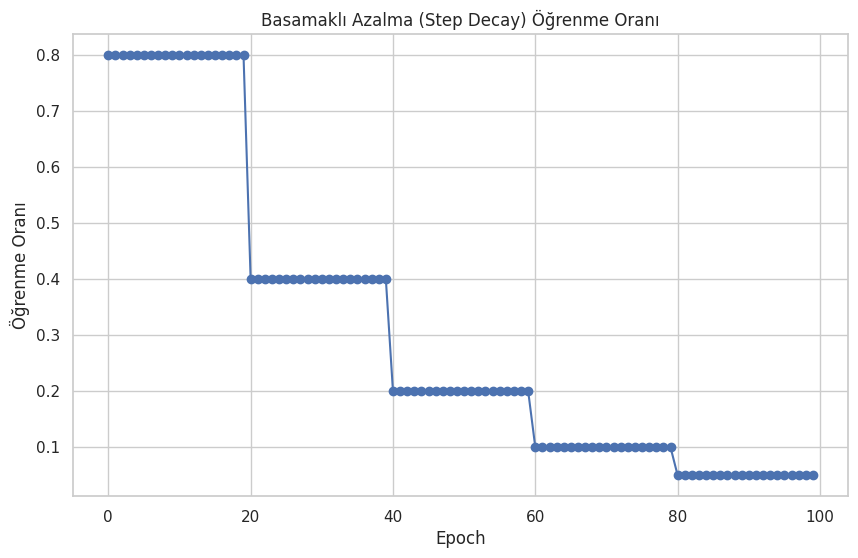

Grafik başarıyla çizildi. Öğrenme oranındaki basamaklı azalmaları gözlemleyin.


In [15]:
# Test ve Görselleştirme (Bu bloğu değiştirmenize gerek yok)
test_epochs_ex2 = 100
try:
    learning_rates_over_time = [step_decay_lr(e) for e in range(test_epochs_ex2)]

    plt.figure(figsize=(10, 6))
    plt.plot(range(test_epochs_ex2), learning_rates_over_time, '-o')
    plt.title('Basamaklı Azalma (Step Decay) Öğrenme Oranı')
    plt.xlabel('Epoch')
    plt.ylabel('Öğrenme Oranı')
    plt.grid(True)
    plt.show()
    print("Grafik başarıyla çizildi. Öğrenme oranındaki basamaklı azalmaları gözlemleyin.")
except NotImplementedError:
    print("step_decay_lr fonksiyonunu henüz tamamlamadınız.")
except Exception as e:
    print(f"Bir hata oluştu: {e}. Kodunuzu kontrol edin.")

---
## Alıştırma 3: Erken Durdurma Simülasyonu

**Amaç:** Aşırı öğrenmeyi (overfitting) önlemek için kullanılan "erken durdurma" (early stopping) mantığını kodlamak.

**Teori:** Erken durdurma, modelin eğitim verisini ezberlemeye başladığı noktayı tespit etmek için bir doğrulama (validation) veri seti kullanır. Doğrulama setindeki hata (loss), belirli bir "sabır" (`patience`) periyodu boyunca iyileşme göstermezse, eğitim durdurulur.

**Göreviniz:** Size verilen `training_losses` ve `validation_losses` listeleri üzerinde gezinen bir döngü yazın. Bu döngü, en iyi doğrulama kaybını ve o zamandan beri kaç epoch geçtiğini takip etmelidir. Doğrulama kaybı `patience` epoch boyunca iyileşmezse, döngü durmalı ve en iyi epoch'u bildirmelidir.

In [23]:
# # Simüle edilmiş kayıp değerleri (Bu bloğu değiştirmeyin)
# np.random.seed(42)
# # Eğitim kaybı genellikle azalır
# training_losses = np.exp(-np.linspace(0, 2, 100)) + np.random.rand(100) * 0.05
# # Doğrulama kaybı bir noktadan sonra artmaya başlar (overfitting simülasyonu)
# validation_losses = training_losses + np.sin(np.linspace(0, 6, 100)) * 0.1 + np.linspace(0, 0.2, 100)


# def early_stopping_simulation(val_losses: np.ndarray, patience: int = 10) -> int:
#     best_loss = float('inf')  # Şimdiye kadar görülen en iyi (en düşük) doğrulama kaybı
#     best_epoch = 0           # En iyi kaybın görüldüğü epoch numarası
#     patience_counter = 0     # Kaybın iyileşmediği epoch sayısı
#     stopped_epoch = -1       # Eğitimin durdurulduğu epoch (-1 ise durdurulmadı)

#     print(f"Erken durdurma simülasyonu başlatıldı. patience = {patience}")

#     for epoch, current_loss in enumerate(val_losses):
#         # print(f"Epoch {epoch}: Validation Loss = {current_loss:.4f}, Best Loss = {best_loss:.4f}, Patience Counter = {patience_counter}") # Hata ayıklama için

#         # --- KODUNUZU BURAYA YAZIN ---
#         # 1. Mevcut doğrulama kaybını (current_loss) en iyi kayıpla (best_loss) karşılaştırın.
#         #    - Eğer current_loss < best_loss ise:
#         #        - best_loss'u current_loss ile güncelleyin.
#         #        - best_epoch'u mevcut epoch numarası ile güncelleyin.
#         #        - patience_counter'ı 0'a sıfırlayın (çünkü iyileşme oldu).
#         #    - Değilse (current_loss >= best_loss ise):
#         #        - patience_counter'ı 1 artırın (çünkü iyileşme olmadı).


#         # 2. patience_counter'ın patience limitine ulaşıp ulaşmadığını kontrol edin.
#         #    - Eğer patience_counter >= patience ise:
#         #        - Eğitimin durdurulduğu epoch'u (stopped_epoch) mevcut epoch numarası yapın.
#         #        - Döngüyü sonlandırmak için `break` kullanın.


#         # --- KODUNUZ BİTTİ ---

#     # Sonuçları yazdırma (Bu kısmı değiştirmeyin)
#     if best_epoch == 0 and best_loss == float('inf'): # Eğer döngü hiç çalışmadıysa veya loss hep inf kaldıysa
#        print("Uyarı: En iyi kayıp hiç güncellenmedi. Kodunuzu kontrol edin veya patience değerini artırın.")
#        return -1 # Hata veya tamamlanmamış durumu belirtir

#     print(f"En iyi doğrulama kaybı {best_loss:.4f}, {best_epoch}. epoch'ta bulundu.")
#     if stopped_epoch != -1:
#         print(f"Eğitim, {stopped_epoch}. epoch'ta erken durduruldu ({patience_counter} epoch iyileşme olmadı).")
#     else:
#         print("Eğitim, erken durdurma tetiklenmeden tamamlandı.")

#     return best_epoch

import numpy as np

# 1) Simüle edilmiş kayıp değerleri (Bunu değiştirme)
np.random.seed(42)

# Eğitim kaybı genellikle azalır
training_losses = np.exp(-np.linspace(0, 2, 100)) + np.random.rand(100) * 0.05

# Doğrulama kaybı (validation): bir noktadan sonra artmaya başlar (overfitting simülasyonu)
validation_losses = training_losses + np.sin(np.linspace(0, 6, 100)) * 0.1 + np.linspace(0, 0.2, 100)


# 2) Early Stopping fonksiyonu
def early_stopping_simulation(val_losses: np.ndarray, patience: int = 10) -> int:
    best_loss = float('inf')   # Şu ana kadarki en iyi (en küçük) val loss
    best_epoch = 0            # En iyi val loss'un görüldüğü epoch
    patience_counter = 0      # İyileşme olmayan üst üste epoch sayısı
    stopped_epoch = -1        # Erken durdurma gerçekleştiyse epoch, yoksa -1

    print(f"Erken durdurma simülasyonu başlatıldı. patience = {patience}")

    for epoch, current_loss in enumerate(val_losses):

        # İyileşme varsa (daha küçük loss gördüysek)
        if current_loss < best_loss:
            best_loss = current_loss
            best_epoch = epoch
            patience_counter = 0  # reset, çünkü iyileşme oldu
        else:
            # İyileşme yoksa patience_counter sayacını artır
            patience_counter += 1

        # patience sınırına geldik mi?
        if patience_counter >= patience:
            stopped_epoch = epoch
            print(f"⏸️ Erken durdurma tetiklendi: {epoch}. epoch'ta, {patience_counter} epoch boyunca iyileşme olmadı.")
            break

    # Güvenlik kontrolü
    if best_epoch == 0 and best_loss == float('inf'):
        print("Uyarı: En iyi kayıp hiç güncellenmedi. Kodunuzu kontrol edin.")
        return -1

    print(f"En iyi doğrulama kaybı {best_loss:.4f}, {best_epoch}. epoch'ta bulundu.")

    if stopped_epoch != -1:
        print(f"Eğitim {stopped_epoch}. epoch'ta erken durduruldu.")
    else:
        print("Eğitim erken durdurma tetiklenmeden tamamlandı.")

    return best_epoch


# 3) Fonksiyonu çağır
best_epoch = early_stopping_simulation(validation_losses, patience=10)
print("\nSonuç: En iyi epoch =", best_epoch)


Erken durdurma simülasyonu başlatıldı. patience = 10
⏸️ Erken durdurma tetiklendi: 93. epoch'ta, 10 epoch boyunca iyileşme olmadı.
En iyi doğrulama kaybı 0.2628, 83. epoch'ta bulundu.
Eğitim 93. epoch'ta erken durduruldu.

Sonuç: En iyi epoch = 83


### Alıştırma 3: Çalıştırma ve Görselleştirme

Aşağıdaki kod bloğu, yazdığınız `early_stopping_simulation` fonksiyonunu çalıştıracak ve eğitim/doğrulama kayıplarını, bulunan en iyi epoch'u ve durdurma noktasını görselleştirecektir. Fonksiyonunuzu doğru yazdıysanız, doğrulama kaybının artmaya başladığı noktadan (`patience` kadar) sonra eğitimin durduğunu gösteren kırmızı çizgiyi görmelisiniz.

Erken durdurma simülasyonu başlatıldı. patience = 15
⏸️ Erken durdurma tetiklendi: 98. epoch'ta, 15 epoch boyunca iyileşme olmadı.
En iyi doğrulama kaybı 0.2628, 83. epoch'ta bulundu.
Eğitim 98. epoch'ta erken durduruldu.


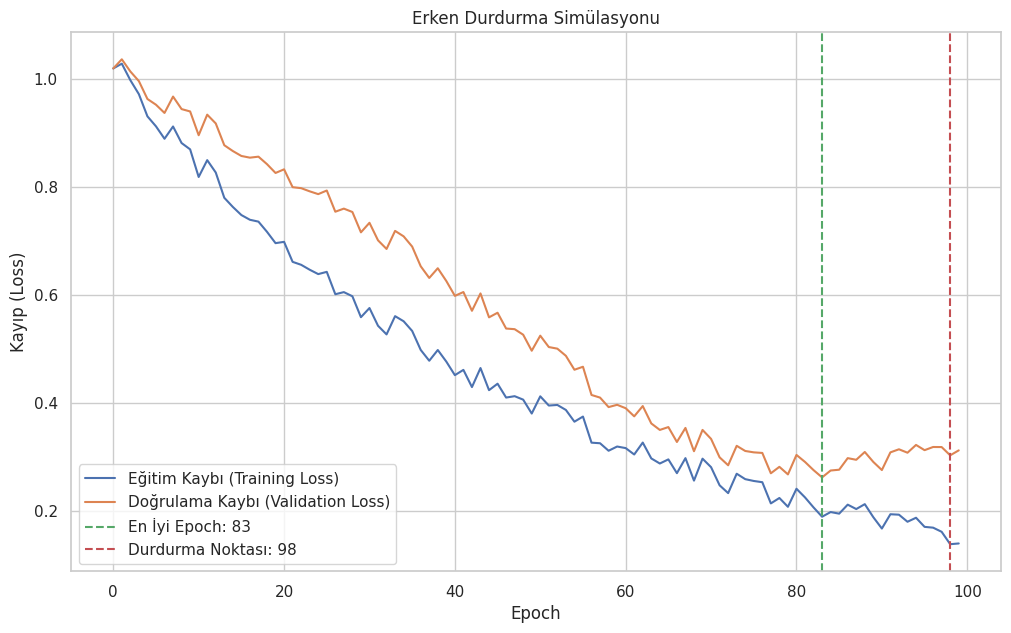

Grafik başarıyla çizildi. Yeşil çizgi en iyi epoch'u, kırmızı çizgi (varsa) eğitimin durduğu noktayı gösterir.


In [24]:
# Test ve Görselleştirme (Bu bloğu değiştirmenize gerek yok)
patience_value_ex3 = 15
best_e_ex3 = early_stopping_simulation(validation_losses, patience=patience_value_ex3)

if best_e_ex3 != -1: # Sadece simülasyon başarıyla çalıştıysa çiz
    plt.figure(figsize=(12, 7))
    plt.plot(training_losses, label='Eğitim Kaybı (Training Loss)')
    plt.plot(validation_losses, label='Doğrulama Kaybı (Validation Loss)')
    plt.axvline(x=best_e_ex3, color='g', linestyle='--', label=f'En İyi Epoch: {best_e_ex3}')
    # Durdurma noktasını çiz (eğer durdurulduysa)
    stop_point = best_e_ex3 + patience_value_ex3
    if stop_point < len(validation_losses): # Eğer patience bitmeden önce durduysa
       plt.axvline(x=stop_point, color='r', linestyle='--', label=f'Durdurma Noktası: {stop_point}')

    plt.title('Erken Durdurma Simülasyonu')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp (Loss)')
    plt.legend()
    plt.grid(True)
    plt.ylim(min(training_losses.min(), validation_losses.min()) - 0.05, max(training_losses.max(), validation_losses.max()) + 0.05) # Y eksenini ayarla
    plt.show()
    print("Grafik başarıyla çizildi. Yeşil çizgi en iyi epoch'u, kırmızı çizgi (varsa) eğitimin durduğu noktayı gösterir.")
else:
     print("Simülasyon tamamlanmadığı veya hata verdiği için grafik çizilemedi.")

---
## Alıştırma 4: Basit Adam Optimize Edicisi

**Amaç:** Modern bir optimize edici olan Adam'ın basitleştirilmiş bir versiyonunu kodlamak.

**Teori:** Adam (Adaptive Moment Estimation), her bir parametre için ayrı öğrenme oranları tutan bir optimize edicidir. Bunu, gradyanların hem birinci momentini (momentum gibi) hem de ikinci momentini (karesel gradyanlar, varyans gibi) takip ederek yapar.

- **Güncelleme Kuralları (Basitleştirilmiş):**
  1. $m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$  (Momentum)
  2. $v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$  (Varyans)
  3. $x_t = x_{t-1} - \alpha \frac{m_t}{\sqrt{v_t} + \epsilon}$
  (Burada $g_t$ gradyan, $m$ ve $v$ moment vektörleri, $\beta_1, \beta_2$ bozulma oranları, $\alpha$ öğrenme oranı, $\epsilon$ ise sıfıra bölmeyi önleyen küçük bir sabittir.)

**Göreviniz:** Aşağıdaki `simple_adam` fonksiyonunu, yukarıdaki kuralları uygulayacak şekilde tamamlayın. Bu, bu serideki en zorlu alıştırmadır!

In [25]:
# def simple_adam(
#     start_xy: List[float],
#     func: Callable[[torch.Tensor], torch.Tensor],
#     lr: float,
#     iters: int,
#     beta1: float = 0.9,
#     beta2: float = 0.999,
#     epsilon: float = 1e-8
# ) -> np.ndarray:

#     xy = torch.tensor(start_xy, dtype=torch.float32, requires_grad=True)
#     history: List[List[float]] = []
#     m = torch.zeros_like(xy) # Birinci moment (momentum)
#     v = torch.zeros_like(xy) # İkinci moment (varyans)

#     print(f"Basit Adam optimizasyonu başlatıldı: lr={lr}, beta1={beta1}, beta2={beta2}")

#     for i in range(iters):
#         history.append(xy.detach().clone().tolist())
#         loss = func(xy)
#         loss.backward()

#         grad = xy.grad
#         if grad is not None:
#             with torch.no_grad():
#                 # --- KODUNUZU BURAYA YAZIN ---
#                 # 1. Birinci moment (m) vektörünü güncelleyin.
#                 #    İpucu: m = beta1 * m_prev + (1 - beta1) * grad


#                 # 2. İkinci moment (v) vektörünü güncelleyin.
#                 #    İpucu: v = beta2 * v_prev + (1 - beta2) * (grad**2)
#                 #    Gradyanın karesini almayı unutmayın!


#                 # 3. Parametre (xy) tensörünü Adam kuralına göre güncelleyin.
#                 #    İpucu: xy = xy_prev - lr * m / (torch.sqrt(v) + epsilon)
#                 #    torch.sqrt() fonksiyonunu ve epsilon'u kullanın.


#                 # --- KODUNUZ BİTTİ ---

#             # Gradyanları sıfırlama
#             if xy.grad is not None:
#                 xy.grad.zero_()
#         else:
#             print(f"Uyarı: {i}. iterasyonda gradyan hesaplanamadı.")
#             break # Gradyan yoksa devam etmenin anlamı yok

#     print("Optimizasyon tamamlandı.")
#     # Eksik kod durumunda hata vermek yerine boş array döndürelim
#     if not history:
#         print("Uyarı: History listesi boş. Kodunuzda bir sorun olabilir.")
#         return np.array([start_xy]) # En azından başlangıç noktasını döndür

#     # Eğer kodunuzu yazmadıysanız, burası çalışmayacak ve history boş kalacaktır.
#     # Bu yüzden yukarıdaki kontrolü ekledik.
#     if 'm' not in locals() or 'v' not in locals(): # Eğer m ve v hiç atanmadıysa (kod yazılmadıysa)
#          print("Uyarı: Adam güncelleme adımları uygulanmamış gibi görünüyor.")
#          # raise NotImplementedError("Adam güncelleme adımlarını tamamlamanız gerekiyor.")

#     return np.array(history)

def simple_adam(
    start_xy: List[float],
    func: Callable[[torch.Tensor], torch.Tensor],
    lr: float,
    iters: int,
    beta1: float = 0.9,
    beta2: float = 0.999,
    epsilon: float = 1e-8
) -> np.ndarray:

    xy = torch.tensor(start_xy, dtype=torch.float32, requires_grad=True)
    history: List[List[float]] = []
    m = torch.zeros_like(xy)  # Birinci moment (momentum)
    v = torch.zeros_like(xy)  # İkinci moment (varyans)

    print(f"Basit Adam optimizasyonu başlatıldı: lr={lr}, beta1={beta1}, beta2={beta2}")

    for i in range(iters):
        history.append(xy.detach().clone().tolist())

        # Vektörize fonksiyonlarla uyum için .sum() güvenli (tek nokta ise zaten skalar)
        loss = func(xy).sum()
        loss.backward()

        grad = xy.grad
        if grad is not None:
            with torch.no_grad():
                # 1️⃣ Birinci moment: gradyanların yumuşatılmış ortalaması
                m = beta1 * m + (1 - beta1) * grad

                # 2️⃣ İkinci moment: gradyan karelerinin yumuşatılmış ortalaması
                v = beta2 * v + (1 - beta2) * (grad ** 2)

                # 3️⃣ Adam güncellemesi: her parametreye özel adım büyüklüğü
                xy -= lr * m / (torch.sqrt(v) + epsilon)

            # Gradyanı sıfırla
            xy.grad.zero_()
        else:
            print(f"Uyarı: {i}. iterasyonda gradyan hesaplanamadı.")
            break

    print("Optimizasyon tamamlandı.")

    if not history:
        print("Uyarı: History listesi boş. Kodunuzda bir sorun olabilir.")
        return np.array([start_xy])

    return np.array(history)


### Alıştırma 4: Çalıştırma ve Karşılaştırma

Aşağıdaki kod bloğu, yazdığınız `simple_adam` fonksiyonunu ve Alıştırma 1'deki `gradient_descent_with_momentum` fonksiyonunu **Himmelblau** fonksiyonu üzerinde, zorlu bir başlangıç noktası olan (0,0)'dan başlatarak çalıştıracaktır. Adam'ın bu noktadan nasıl kurtulabildiğini, momentumun ise nasıl takılıp kaldığını gözlemleyin.

Basit Adam optimizasyonu başlatıldı: lr=0.1, beta1=0.9, beta2=0.999
Optimizasyon tamamlandı.


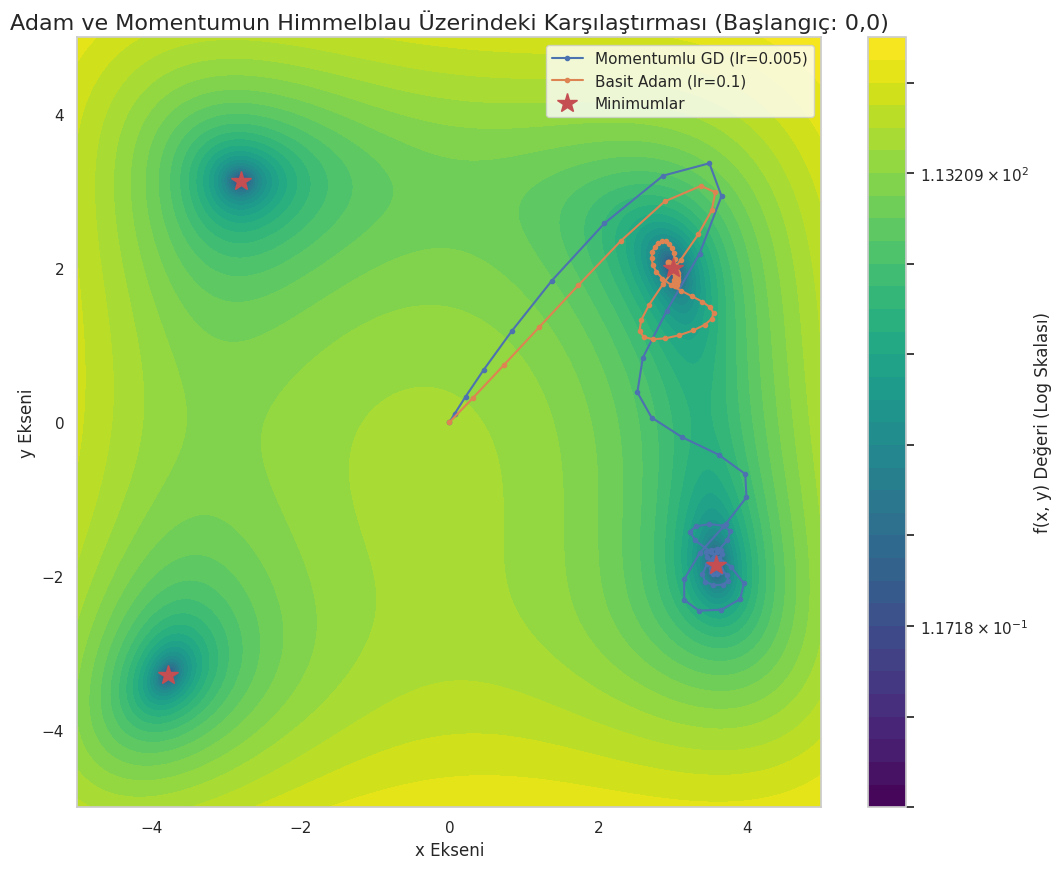

Görselleştirme başarılı! Adam'ın (0,0) noktasından nasıl kaçabildiğine dikkat edin.


In [26]:
# Karşılaştırma Deneyi (Bu bloğu değiştirmenize gerek yok)
start_point_adam_ex4 = [0.0, 0.0] # Zorlu bir başlangıç noktası (eyer noktası yakınında)
iters_adam_ex4 = 100
lr_adam_ex4 = 0.1
lr_momentum_ex4 = 0.005 # Momentum için daha küçük bir öğrenme oranı gerekebilir

try:
    # Adam'ı çalıştır
    path_adam = simple_adam(start_point_adam_ex4, himmelblau, lr=lr_adam_ex4, iters=iters_adam_ex4)

    # Momentumu çalıştır
    path_momentum_adam = gradient_descent_with_momentum(start_point_adam_ex4, himmelblau, lr=lr_momentum_ex4, iters=iters_adam_ex4)

    # Sonuçları çizdir
    plot_paths(
        {f'Momentumlu GD (lr={lr_momentum_ex4})': path_momentum_adam, f'Basit Adam (lr={lr_adam_ex4})': path_adam},
        himmelblau,
        'Adam ve Momentumun Himmelblau Üzerindeki Karşılaştırması (Başlangıç: 0,0)'
    )
    print("Görselleştirme başarılı! Adam'ın (0,0) noktasından nasıl kaçabildiğine dikkat edin.")

except NotImplementedError:
    print("simple_adam fonksiyonunu henüz tamamlamadınız.")
except Exception as e:
    print(f"Bir hata oluştu: {e}. Kodunuzu kontrol edin.")

---
## Alıştırma 5: Hiperparametre Izgara Taraması

**Amaç:** En iyi hiperparametre kombinasyonunu bulmak için sistematik bir arama yapmak.

**Teori:** "Izgara Taraması" (Grid Search), denemek istediğiniz hiperparametreler için bir dizi değer belirleyip, bu değerlerin tüm olası kombinasyonlarını deneyerek en iyi sonucu vereni bulma yöntemidir.

**Göreviniz:** Momentumlu gradyan inişi için en iyi `öğrenme oranı` ve `beta` (momentum katsayısı) kombinasyonunu bulmak üzere bir ızgara taraması yapın. Verilen `learning_rates_grid` ve `betas_grid` listeleri üzerinde iç içe iki döngü kurun, her kombinasyon için optimizasyonu çalıştırın ve en düşük final kayba ulaşan kombinasyonu raporlayın.

In [27]:
# # Taranacak hiperparametre değerleri (Bu listeleri değiştirmeyin)
# learning_rates_grid = [0.0005, 0.001, 0.002]
# betas_grid = [0.8, 0.9, 0.95]

# def grid_search() -> Tuple[float, float, float]:
#     best_loss = float('inf')
#     best_params: Dict[str, float] = {'lr': 0.0, 'beta': 0.0}
#     start_point = [-2.0, 2.0] # Rosenbrock için başlangıç noktası
#     iters = 100             # Her deneme için iterasyon sayısı
#     func_to_optimize = rosenbrock # Optimize edilecek fonksiyon

#     print("Izgara Taraması Başlatıldı...")

#     # --- KODUNUZU BURAYA YAZIN ---
#     # 1. learning_rates_grid üzerinde dönen bir dış döngü kurun.
#     for lr in learning_rates_grid:
#         # 2. betas_grid üzerinde dönen bir iç döngü kurun.
#         for beta in betas_grid:
#             print(f"Deniyor: lr={lr}, beta={beta}", end=" -> ")
#             try:
#                 # 3. İç döngüde, mevcut lr ve beta değerleri ile
#                 #    `gradient_descent_with_momentum` fonksiyonunu çağırın.
#                 #    Fonksiyon olarak `func_to_optimize` kullanın.
#                 # path = ...
#                 path = gradient_descent_with_momentum(start_point, func_to_optimize, lr, iters, beta)

#                 # 4. Optimizasyon sonucunda dönen path'in son noktasını alın.
#                 # final_point = ...
#                 final_point = path[-1]

#                 # 5. Son noktanın `func_to_optimize` fonksiyonundaki değerini (kaybını) hesaplayın.
#                 #    torch tensoruna çevirip .item() ile Python float değeri alın.
#                 # final_loss = ...
#                 final_loss = func_to_optimize(torch.tensor(final_point)).item()

#                 print(f"Final Loss: {final_loss:.4f}")

#                 # 6. Hesaplanan final_loss'u şimdiye kadarki en iyi kayıp (best_loss) ile karşılaştırın.
#                 #    - Eğer final_loss < best_loss ise:
#                 #        - best_loss'u final_loss ile güncelleyin.
#                 #        - best_params sözlüğündeki 'lr' ve 'beta' değerlerini güncelleyin.
#                 if final_loss < best_loss:
#                     best_loss = final_loss
#                     best_params['lr'] = lr
#                     best_params['beta'] = beta
#                     print(f"*** Yeni en iyi bulundu! ***")

#             except Exception as e:
#                  print(f"Hata oluştu: {e}") # NaN veya başka hataları yakala
#     # --- KODUNUZ BİTTİ ---

#     # Sonuçları yazdırma (Bu kısmı değiştirmeyin)
#     print("\nIzgara Taraması Tamamlandı!")
#     if best_params['lr'] == 0.0: # Eğer hiç güncelleme olmadıysa
#         print("Uyarı: En iyi parametreler bulunamadı. Kodunuzu veya grid aralığını kontrol edin.")
#         return 0.0, 0.0, best_loss # Varsayılan değerleri döndür

#     print(f"En iyi parametreler: Öğrenme Oranı = {best_params['lr']}, Beta = {best_params['beta']}")
#     print(f"Ulaşılan en düşük kayıp: {best_loss:.6f}")
#     return best_params['lr'], best_params['beta'], best_loss

# Taranacak hiperparametre değerleri (Bu listeleri değiştirmeyin)
learning_rates_grid = [0.0005, 0.001, 0.002]
betas_grid = [0.8, 0.9, 0.95]

def grid_search() -> Tuple[float, float, float]:
    best_loss = float('inf')
    best_params: Dict[str, float] = {'lr': 0.0, 'beta': 0.0}
    start_point = [-2.0, 2.0]   # Rosenbrock için başlangıç noktası
    iters = 100                 # Her deneme için iterasyon sayısı
    func_to_optimize = rosenbrock

    print("Izgara Taraması Başlatıldı...")

    # 1. learning_rates_grid üzerinde dön
    for lr in learning_rates_grid:
        # 2. betas_grid üzerinde dön
        for beta in betas_grid:
            print(f"Deniyor: lr={lr}, beta={beta}", end=" -> ")
            try:
                # 3. Momentumlu GD ile optimize et
                path = gradient_descent_with_momentum(
                    start_xy=start_point,
                    func=func_to_optimize,
                    lr=lr,
                    iters=iters,
                    beta=beta
                )

                # 4. Son noktayı al
                final_point = path[-1]  # [x, y]

                # 5. Son noktadaki loss'u hesapla
                final_tensor = torch.tensor(final_point, dtype=torch.float32)
                final_loss = func_to_optimize(final_tensor).sum().item()

                print(f"Final Loss: {final_loss:.6f}")

                # 6. En iyi sonucu güncelle
                if final_loss < best_loss:
                    best_loss = final_loss
                    best_params['lr'] = lr
                    best_params['beta'] = beta
                    print(f"*** Yeni en iyi bulundu! ***")

            except Exception as e:
                print(f"Hata oluştu: {e}")

    print("\nIzgara Taraması Tamamlandı!")

    if best_params['lr'] == 0.0:
        print("Uyarı: En iyi parametreler bulunamadı. Kodunuzu veya grid aralığını kontrol edin.")
        return 0.0, 0.0, best_loss

    print(f"En iyi parametreler: Öğrenme Oranı = {best_params['lr']}, Beta = {best_params['beta']}")
    print(f"Ulaşılan en düşük kayıp: {best_loss:.6f}")

    return best_params['lr'], best_params['beta'], best_loss


### Alıştırma 5: Çalıştırma

Aşağıdaki kod bloğu, yazdığınız `grid_search` fonksiyonunu çalıştıracaktır. Her bir hiperparametre kombinasyonunun denendiğini ve final kayıplarının yazdırıldığını görmelisiniz. Sonunda en iyi bulunan parametreler ve ulaşılan en düşük kayıp raporlanacaktır.

Izgara Taraması Başlatıldı...
Deniyor: lr=0.0005, beta=0.8 -> Final Loss: 1.158856
*** Yeni en iyi bulundu! ***
Deniyor: lr=0.0005, beta=0.9 -> Final Loss: 0.010928
*** Yeni en iyi bulundu! ***
Deniyor: lr=0.0005, beta=0.95 -> Final Loss: 2.644566
Deniyor: lr=0.001, beta=0.8 -> Final Loss: 0.180151
Deniyor: lr=0.001, beta=0.9 -> Final Loss: 0.285161
Deniyor: lr=0.001, beta=0.95 -> Final Loss: nan
Deniyor: lr=0.002, beta=0.8 -> Final Loss: nan
Deniyor: lr=0.002, beta=0.9 -> Final Loss: nan
Deniyor: lr=0.002, beta=0.95 -> Final Loss: nan

Izgara Taraması Tamamlandı!
En iyi parametreler: Öğrenme Oranı = 0.0005, Beta = 0.9
Ulaşılan en düşük kayıp: 0.010928


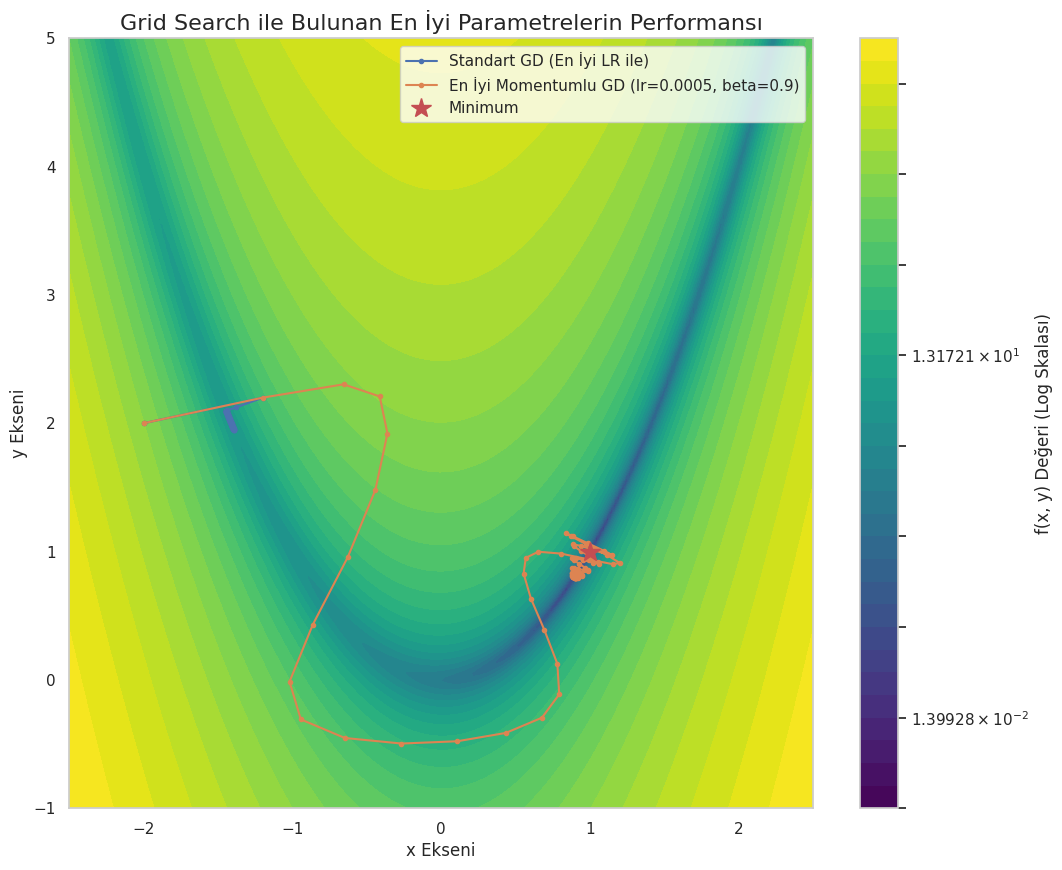

In [28]:
# Grid Search'ü Çalıştır (Bu bloğu değiştirmenize gerek yok)
try:
    best_lr_ex5, best_beta_ex5, best_final_loss_ex5 = grid_search()

    # En iyi bulunan parametrelerle bir kez daha çalıştırıp görselleştirelim (isteğe bağlı)
    if best_lr_ex5 != 0.0: # Sadece geçerli parametre bulunduysa
        start_point_ex5 = [-2.0, 2.0]
        iters_ex5 = 200 # Daha uzun süre çalıştırabiliriz
        path_best_momentum = gradient_descent_with_momentum(
            start_point_ex5,
            rosenbrock,
            best_lr_ex5,
            iters_ex5,
            best_beta_ex5
        )
        path_standard_ex5 = standard_gd(start_point_ex5, rosenbrock, best_lr_ex5, iters_ex5) # Karşılaştırma için standart GD

        plot_paths(
            {'Standart GD (En İyi LR ile)': path_standard_ex5, f'En İyi Momentumlu GD (lr={best_lr_ex5}, beta={best_beta_ex5})': path_best_momentum},
            rosenbrock,
            'Grid Search ile Bulunan En İyi Parametrelerin Performansı',
             x_range=(-2.5, 2.5), y_range=(-1, 5)
        )
except NotImplementedError:
     print("gradient_descent_with_momentum veya grid_search fonksiyonu henüz tamamlanmadı.")
except Exception as e:
     print(f"Bir hata oluştu: {e}. Kodunuzu kontrol edin.")

---
## Tebrikler!

Bu notebook'taki tüm alıştırmaları tamamladınız. Momentum, öğrenme oranı zamanlaması, erken durdurma, Adam optimize edicisi ve hiperparametre taraması gibi önemli optimizasyon tekniklerini pratik olarak uyguladınız. Bu bilgiler, derin öğrenme modellerinizi daha etkili bir şekilde eğitmenize yardımcı olacaktır.